### Import Library

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['axes.unicode_minus'] = False
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
from argparse import Namespace
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error

import sys
sys.path.insert(1, "/Users/yeojisu/Documents/House-Price-Index-Prediction")

from utils.data_loader import *
from config.config_US import *

### Load Data

In [3]:
target_df = load_target_data_us(TARGET_PATH)
df = load_feature_data_us(FEATURE_PATH, FEATURE_COLUMN, TRAIN_DATE)
df = pd.concat([df,target_df],axis = 1) 
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df = df.dropna()

date = 'Date'
df = df.reset_index(names=date) 
df[date] = pd.to_datetime(df[date]) 
df.reset_index(drop=True, inplace=True)
df.index.name = "num"


### Choose Model: xPatch, CARD, Dlinear, Nlinear

In [ ]:
"""
    Must Choose Model
    * DLinear
    * NLinear
    * xPatch
    * CARD
"""
# from DLinear import Model
from NLinear import Model
# from xPatch import Model
# from CARD import Model
model_name = "Nlinear"

In [ ]:
### Experiment Setting
window_size = WINDOW_SIZE
forecast_size= FORECAST_HORIZON
idx = df[df.Date == TEST_DATE].index[0]
train_df = df[:idx]
test_df = df[idx-(forecast_size+window_size):]
test_df.reset_index(drop=True, inplace=True)
test_df.index.name = "num"
dir_path = "/Users/yeojisu/Documents/HPI-Save/USA/Baseline/recent/"
version = f"{forecast_size}month_{model_name}"
columns_to_use = FEATURE_COLUMN + target_df.columns.tolist()

batch_size = 16
epoch_ = 500
lr = 0.001
former_lr = 0.0005
patience = 20  # easrly stopping

configs = Namespace( # Convert configs dictionary to Namespace
    # Dlinear, Nlinear
    seq_len=window_size,  # Set minimum input length to 1
    pred_len=forecast_size,
    individual=False, 
    enc_in= len(columns_to_use), # feature_size
    
    # xPatch
    ker_len=25,                         # Kernel size
    patch_len = 3,                      # Length of each patch
    stride = 2,                         # Patch interval
    padding_patch = 'end',
    revin = True,
    ma_type = 'ema',
    alpha = 0.3,                        # EMA coefficient
    beta = 0.3,
    
    # CARD
    patch_size = 3,
    d_model = 128,                      # Hidden dimension of the model
    dropout = 0.1,                      # Dropout rate
    e_layers = 4,                       # Number of encoder layers
    n_heads = 8,                        # Number of heads in multi-head attention
    use_statistic = True,               # Whether to use statistical values
    total_token_number = 3,             # Total number of tokens
    d_ff = 256,                         # Dimension of the feedforward network
    momentum = 0.1,                     # Momentum for batch normalization
    dp_rank = 16,                       # Rank of dynamic projection
    merge_size = 4,                     # Merge size
    
)

In [ ]:
model = Model(configs=configs)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr) # CARD -> former_lr

# Prepare Dataset
train_df_fe, test_df_fe, mean_, std_ = standardization(train_df, test_df, date, columns_to_use)
    
train_x, train_y, train_date = time_slide_df(train_df_fe, window_size, forecast_size, date, columns_to_use)
test_x, test_y, test_date = time_slide_df(test_df_fe, window_size, forecast_size, date, columns_to_use)
    
# Prepare DataLoader 
train_ds = Data(train_x, train_y)
test_ds = Data(test_x, test_y)

### Train

In [146]:
train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle=False)
test_dl  = DataLoader(test_ds,  batch_size = len(test_df), shuffle=False)
# Train the model 
train_loss_list = [] # save the train loss
test_loss_list = [] # save the test loss

max_loss = 999999999
patience_counter = 0

 18%|█▊        | 90/500 [00:25<01:56,  3.51it/s]

Early stopping triggered.


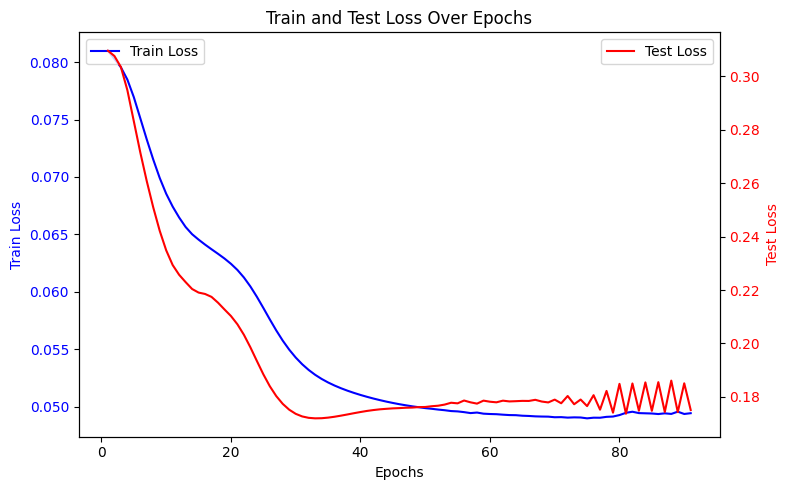

In [78]:
for epoch in tqdm(range(1, epoch_+1)):
    loss_list = []
    model.train()
    train_loss = 0.0 
    for batch_idx, (data, target) in enumerate(train_dl):
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
        
    train_loss = np.mean(loss_list) 
    train_loss_list.append(train_loss) 

    model.eval()
    with torch.no_grad():
        test_loss_list_epoch = []
        for data, target in test_dl:
            output = model(data)
            test_loss = criterion(output, target)
            test_loss_list_epoch.append(test_loss.item())
            
        test_loss = np.mean(test_loss_list_epoch)
        test_loss_list.append(test_loss)

    if train_loss < max_loss:
        torch.save(model.state_dict(), dir_path+f"model_{version}.pth")
        max_loss = train_loss
        # print("Train_loss={:.3f}, Test_loss={:.3f}, Model Saved".format(train_loss, test_loss))
        dlinear_best_epoch = epoch
        dlinear_best_train_loss = train_loss
        dlinear_best_test_loss = test_loss
    else:
        patience_counter += 1
        # print("Train_loss={:.3f}, Test_loss={:.3f}, Patience: {}/{}".format(train_loss, test_loss, patience_counter, patience))
    
    if patience_counter >= patience:
        print("Early stopping triggered.")
        break
    
fig, ax1 = plt.subplots(figsize=(8, 5))
epochs = range(1, len(train_loss_list) + 1)
ax1.plot(epochs, train_loss_list, label='Train Loss', color='b')
ax1.set_xlabel('Epochs')
ax1.set_ylabel("Train Loss",color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.legend(loc="upper left")
# ax1.grid()
ax2 = ax1.twinx()
ax2.plot(epochs, test_loss_list, label='Test Loss',color='r')
ax2.set_xlabel('Epochs')
ax2.set_ylabel("Test Loss",color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax2.legend(loc="upper right") 
# ax2.grid()
plt.title('Train and Test Loss Over Epochs')
fig.tight_layout()
plt.show()
    

### Forecast

In [ ]:
# Load model and Evaluate
model.load_state_dict(torch.load(dir_path+f"model_{version}.pth"))
model.eval()

train_dl  = DataLoader(train_ds,  batch_size = len(train_df), shuffle=False)
test_dl  = DataLoader(test_ds,  batch_size = len(test_df), shuffle=False)
with torch.no_grad():
    for data, target in train_dl:
        train_output = model(data)
        train_predicted = train_output[:, -1, :].cpu().numpy()  # Last timestep predictions
        train_actual = target[:, -1, :].cpu().numpy()     # Last timestep actual values
        train_dates = train_date[:, -1]                    # Dates corresponding to the last forecast
    
    for data, target in test_dl:
        test_output = model(data)
        test_predicted = test_output[:, -1, :].cpu().numpy()  # Last timestep predictions
        test_actual = target[:, -1, :].cpu().numpy()     # Last timestep actual values
        test_dates = test_date[:, -1]  
    
plt.figure(figsize=(20, len(columns_to_use) * 6))  # Adjust the figure size as needed
for i in range(len(columns_to_use)):
    idv_mean = mean_[columns_to_use[i]]
    idv_std = std_[columns_to_use[i]]
    
    real = test_actual[:, i]*idv_std+idv_mean
    pred = test_predicted[:, i]*idv_std+idv_mean
    rmse = round(mean_squared_error(real, pred)**0.5,3)
    mae = round(mean_absolute_error(real, pred),3)
    if columns_to_use[i] in target_df.columns:
        val = [columns_to_use[i].split("_")[0], rmse, mae]
        pd.DataFrame(val).T.to_csv(dir_path+f"result_{version}.csv", mode='a', header=False, index=False)
        # pd.DataFrame(pred, columns = [columns_to_use[i].split("_")[0]]).T.to_csv(dir_path+f"pred_{version}.csv", mode='a', header=False)
    plt.subplot(len(columns_to_use), 1, i + 1)
    plt.plot(df['Date'], df[columns_to_use[i]])
    plt.plot(train_dates, train_actual[:, i]*idv_std+idv_mean, c="b")
    plt.plot(train_dates, train_predicted[:, i]*idv_std+idv_mean, linestyle='--', c="r")
    plt.axvline(x=test_dates[0], color='black', linestyle=':', linewidth=3,label="Test Start")
    plt.plot(test_dates, test_actual[:, i]*idv_std+idv_mean, label='Actual Data', c="b")
    plt.plot(test_dates, test_predicted[:, i]*idv_std+idv_mean, label='Predicted Data', linestyle='--', c="r")
    plt.title(f'Forecast vs Actuals for {columns_to_use[i]}')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()

<Figure size 2000x21600 with 0 Axes>